In [157]:
from pydantic import BaseModel, Field
from typing import TypedDict, List, Dict, Annotated, Literal
import operator
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
import os
load_dotenv()

os.environ["GORQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

class AgentState(TypedDict):
    user_input: Annotated[str, Field(description="This is user question.")]
    user_tasks: Annotated[list[str], Field(description="The list of user task")]
    # user_notes: Annotated[Dict[str, str], Field(description="This is the user all Notes about relevant topics."), operator.add]
    user_notes: Annotated[list[str], Field(description="This is the user all Notes about relevant topics.")]
    output_response: Annotated[str, Field(description="Output of the agent like its completed the user assign task.")]
    route_node: str

In [158]:
class RouteInput(BaseModel):
    """This is router class its define the user next node based on the user input."""
    
    route: Annotated[Literal["task_manager", "notes_taker"], Field(description="its define based on the user input like what user want to do now.")]

In [159]:
router_planner = llm.with_structured_output(RouteInput)

router_planner.invoke("Currenly i'm done the math assignment.").route

'task_manager'

In [160]:
def route_task(state: AgentState):
    """This is route task node"""
    
    print("----Route task function-----")
    
    input = state["user_input"]
    
    system_msg = f"""Think you are a manager and you assign task based on the user input. You have only two option like task_manager which doing to-do related task its just store that task. And another one is notes_taker worker who take the notes or make report based on the user topics.\n
    user input is: {input}\n\n
    
    output will be: task_manager or notes_taker based on the user input.
    """
    
    response = router_planner.invoke([SystemMessage(content=system_msg)])
    return {
        "route_node": response.route
    }

In [161]:
## taskManagerNode
def task_manager(state: AgentState):
    """This is task manager state"""
    
    existing_task = state.get("user_tasks", "")
    
    
    print("---Task Manager Node---")
    system_msg = f"""Think You are a task manager and you will add user task as the bullet point. If user told you about a task you will add this task in the User task list.
    after add the task you will be tell you the user like you add the task in his task list. make sure add the the task in bullet point wise.\n
    this is user existing task: {existing_task} its can be empty. but if not empty the update this list.
    if user told like he finish a task then you will be remove this task form the list.
    and user input is: {state['user_input']}.
    
    
    """
    task_list = llm.invoke([SystemMessage(content=system_msg)])
    
    return {
        "user_tasks": [task_list.content]
    }

In [162]:
def notes_taker(state: AgentState):
    """This is node taker node"""
    
    system_msg = f"Take a node based on the user question: {state['user_input']}"
    
    response = llm.invoke([SystemMessage(content=system_msg)])
    
    return {
        "user_notes": [response.content]
    }

In [163]:
def route(state: AgentState):
    """This is route node"""
    
    if state["route_node"] == "task_manager":
        return "task_manager"
    else:
        return "notes_taker"

## Build the Graph

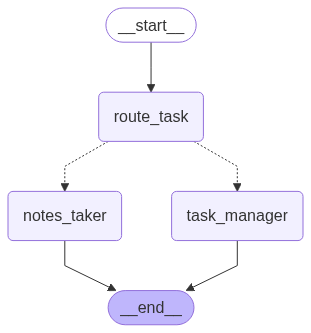

In [164]:
from langgraph.graph import START, END, StateGraph
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(AgentState)

builder.add_node("route_task", route_task)
builder.add_node("task_manager", task_manager)
builder.add_node("notes_taker", notes_taker)

builder.add_edge(START, "route_task")
builder.add_conditional_edges(
    "route_task",
    route,
    {
        "task_manager": "task_manager",
        "notes_taker": "notes_taker"
    }
)
builder.add_edge("task_manager", END)
builder.add_edge("notes_taker", END)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [165]:
config = {"configurable": {"thread_id": "1"}}

In [166]:
graph.invoke(
    {
        "user_input": "I want to do bike ride today 7pm at Dhaka."
    },
    config=config
)

----Route task function-----
---Task Manager Node---


{'user_input': 'I want to do bike ride today 7pm at Dhaka.',
 'user_tasks': ["I'll add the task to your list.\n\nYour current task list:\n* \n\nI've added a new task to your list:\n\nYour updated task list:\n* Bike ride today at 7pm at Dhaka\n\nI'll make sure to keep track of your tasks. Let me know if you need to add, remove or update any task! \n\nWhat else you want to do?"],
 'route_node': 'task_manager'}

In [167]:
graph.invoke(
    {
        "user_input": "crate short notes about the Machine learning for my fist class."
    },
    config=config
)

----Route task function-----


{'user_input': 'crate short notes about the Machine learning for my fist class.',
 'user_tasks': ["I'll add the task to your list.\n\nYour current task list:\n* \n\nI've added a new task to your list:\n\nYour updated task list:\n* Bike ride today at 7pm at Dhaka\n\nI'll make sure to keep track of your tasks. Let me know if you need to add, remove or update any task! \n\nWhat else you want to do?"],
 'user_notes': ["Here are some short notes on Machine Learning for your first class:\n\n**What is Machine Learning?**\n\n* Machine Learning (ML) is a subset of Artificial Intelligence (AI) that enables machines to learn from data without being explicitly programmed.\n* It involves training algorithms to make predictions or decisions based on data.\n\n**Types of Machine Learning:**\n\n1. **Supervised Learning**: The algorithm learns from labeled data to make predictions on new, unseen data.\n\t* Examples: Image classification, sentiment analysis\n2. **Unsupervised Learning**: The algorithm di

In [168]:
graph.get_state(config).values

{'user_input': 'crate short notes about the Machine learning for my fist class.',
 'user_tasks': ["I'll add the task to your list.\n\nYour current task list:\n* \n\nI've added a new task to your list:\n\nYour updated task list:\n* Bike ride today at 7pm at Dhaka\n\nI'll make sure to keep track of your tasks. Let me know if you need to add, remove or update any task! \n\nWhat else you want to do?"],
 'user_notes': ["Here are some short notes on Machine Learning for your first class:\n\n**What is Machine Learning?**\n\n* Machine Learning (ML) is a subset of Artificial Intelligence (AI) that enables machines to learn from data without being explicitly programmed.\n* It involves training algorithms to make predictions or decisions based on data.\n\n**Types of Machine Learning:**\n\n1. **Supervised Learning**: The algorithm learns from labeled data to make predictions on new, unseen data.\n\t* Examples: Image classification, sentiment analysis\n2. **Unsupervised Learning**: The algorithm di

In [169]:
graph.invoke(
    {
        "user_input": "crate short notes about the Deep Learning for my fist class."
    },
    config=config
)

----Route task function-----


{'user_input': 'crate short notes about the Deep Learning for my fist class.',
 'user_tasks': ["I'll add the task to your list.\n\nYour current task list:\n* \n\nI've added a new task to your list:\n\nYour updated task list:\n* Bike ride today at 7pm at Dhaka\n\nI'll make sure to keep track of your tasks. Let me know if you need to add, remove or update any task! \n\nWhat else you want to do?"],
 'user_notes': ['Here are some short notes on Deep Learning that you can use for your first class:\n\n**What is Deep Learning?**\n\n* A subset of Machine Learning (ML) that uses artificial neural networks to analyze data\n* Inspired by the structure and function of the human brain\n* Can learn complex patterns in data without manual feature engineering\n\n**Key Concepts:**\n\n1. **Artificial Neural Networks (ANNs)**: composed of layers of interconnected nodes (neurons) that process and transmit information\n2. **Deep Neural Networks (DNNs)**: ANNs with multiple hidden layers, allowing for hiera

In [170]:
latest_checkpoint = memory.get(config)

# Print the checkpoint details
if latest_checkpoint:
    print("--- Checkpoint Found ---")
    # The actual state values are usually in 'channel_values'
    print("Saved State:", latest_checkpoint)
    # You can also print the whole checkpoint object for more details
    # print("Full Checkpoint:", latest_checkpoint)
else:
    print("No checkpoint found for this config.")


--- Checkpoint Found ---
Saved State: {'v': 3, 'ts': '2025-05-26T12:30:51.243249+00:00', 'id': '1f03a2d4-284e-6d6b-800a-d53376d04d50', 'channel_versions': {'__start__': '00000000000000000000000000000010.0.926700354835655', 'user_input': '00000000000000000000000000000010.0.6709341117135458', 'branch:to:route_task': '00000000000000000000000000000011.0.4696003667929146', 'route_node': '00000000000000000000000000000011.0.7265127211452905', 'branch:to:task_manager': '00000000000000000000000000000004.0.8609281722027584', 'user_tasks': '00000000000000000000000000000004.0.55322648115796', 'branch:to:notes_taker': '00000000000000000000000000000012.0.021689392629896664', 'user_notes': '00000000000000000000000000000012.0.7081689806261078'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000009.0.4335434946756175'}, 'route_task': {'branch:to:route_task': '00000000000000000000000000000010.0.013821105878307982'}, 'task_manager': {'branch:to:task_manager': '0

In [171]:
latest_checkpoint['channel_values']

{'user_input': 'crate short notes about the Deep Learning for my fist class.',
 'route_node': 'notes_taker',
 'user_tasks': ["I'll add the task to your list.\n\nYour current task list:\n* \n\nI've added a new task to your list:\n\nYour updated task list:\n* Bike ride today at 7pm at Dhaka\n\nI'll make sure to keep track of your tasks. Let me know if you need to add, remove or update any task! \n\nWhat else you want to do?"],
 'user_notes': ['Here are some short notes on Deep Learning that you can use for your first class:\n\n**What is Deep Learning?**\n\n* A subset of Machine Learning (ML) that uses artificial neural networks to analyze data\n* Inspired by the structure and function of the human brain\n* Can learn complex patterns in data without manual feature engineering\n\n**Key Concepts:**\n\n1. **Artificial Neural Networks (ANNs)**: composed of layers of interconnected nodes (neurons) that process and transmit information\n2. **Deep Neural Networks (DNNs)**: ANNs with multiple hid